In [59]:
import numpy as np
import pandas as pd
import math, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

### Dataset with phones reviews from Amazon: https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews

### Model development is based on article: https://www.kaggle.com/viniciuscleves/anime-recomendation-based-on-user-clustering

In [3]:
items = pd.read_csv('20191226-items.csv')
items = items[['asin', 'brand', 'rating', 'totalReviews', 'price', 'originalPrice']]
items.rename(columns={'totalReviews': 'total_reviews', 'originalPrice': 'original_price'}, inplace=True)
print('items sample size: {}'.format(items.shape[0]))
items.head()

items sample size: 720


,asin,brand,rating,total_reviews,price,original_price
0,B0000SX2UC,NaN,3.0,14,0.00,0.0
1,B0009N5L7K,Motorola,3.0,7,49.95,0.0
2,B000SKTZ0S,Motorola,2.7,22,99.99,0.0
3,B001AO4OUC,Motorola,3.3,21,0.00,0.0
4,B001DCJAJG,Motorola,3.1,12,149.99,0.0


Some histograms (Maybe it's not bad to put some other comments here)

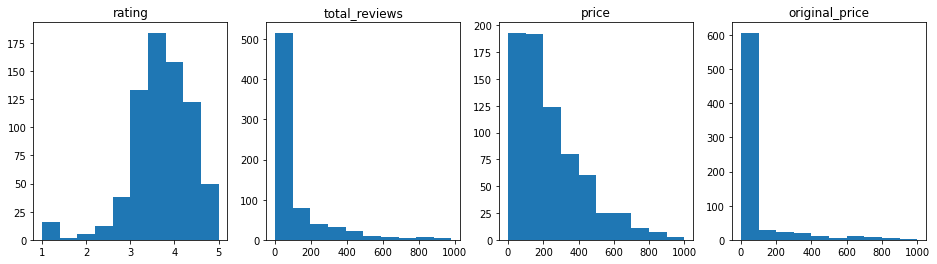

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, col in enumerate(items.columns[2:]):
    axs[i].hist(items[col])
    axs[i].set_title(col)

In [5]:
reviews = pd.read_csv('20191226-reviews.csv')
reviews.rename(columns={'helpfulVotes': 'helpful_votes'}, inplace=True)
print('reviews sample size: {}'.format(reviews.shape[0]))
reviews.head()

reviews sample size: 67986


,asin,name,rating,date,verified,title,body,helpful_votes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [62]:
def to_date(x):
    months = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
        'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    date_list = x.split(' ')
    month = int(months[date_list[0]])
    day = int(date_list[1].replace(',', ''))
    year = int(date_list[2])
    return datetime.datetime(year, month, day)

reviews.date = reviews.date.apply(to_date)
reviews.head()

,asin,name,rating,date,verified,title,body,helpful_votes
0,B0000SX2UC,Janet,3,2005-10-11,False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,2004-01-07,False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,2003-12-30,False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,2004-03-18,False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,2005-08-28,False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


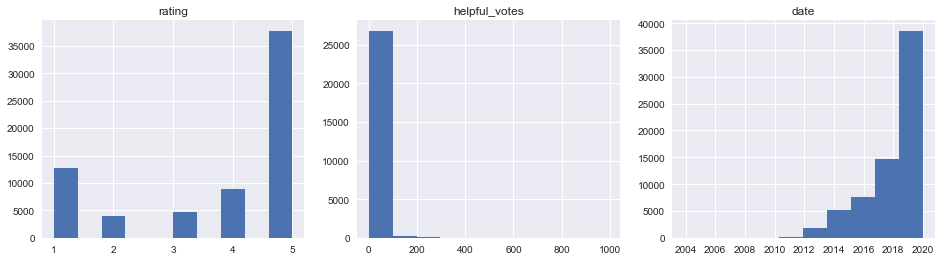

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(['rating', 'helpful_votes', 'date']):
    axs[i].hist(reviews[col])
    axs[i].set_title(col)

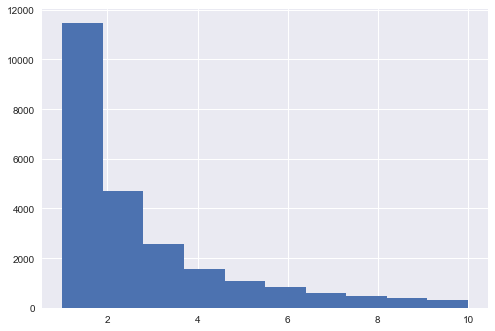

In [75]:
_ = plt.hist(reviews.loc[reviews.helpful_votes<=10, 'helpful_votes'])

### User-based model

Selecting cumstomers, who has n (n = MIN_REVIEW_NUM) and more reviews, verified reviews

In [179]:
reviews1 = reviews[reviews.verified==True]

MIN_REVIEW_NUM = 2
pvt = reviews1.groupby(['name']).count().reset_index() # 'count' is not nice, topic for codereview
csm_list = pvt[pvt.asin>=MIN_REVIEW_NUM].name.tolist()

# cusomter has 2 and more reviews
reviews1 = reviews[(reviews.name.isin(csm_list))]
print('sample length: {}'.format(reviews1.shape[0]))

sample length: 25226


In [180]:
# Reviews Frequency (rf) for each customer
rf = pd.DataFrame({'name': reviews1.name.unique()})

mean_timedelta_list = []
for name in tqdm(rf.name):
    temp = reviews1[reviews1.name==name]
    temp = temp.sort_values(by='date').reset_index()
    temp.drop(['index'], axis='columns', inplace=True)
    timedelta_list = []
    for i in range(temp.shape[0]-1):
        timedelta_list.append(temp.loc[i+1, 'date'] - temp.loc[i, 'date'])
    mean_timedelta_list.append(np.mean(timedelta_list))
    
rf = rf.assign(mean_timedelta=pd.DataFrame({'mean_timedelta': mean_timedelta_list}))

100%|██████████| 5380/5380 [00:18<00:00, 291.89it/s]


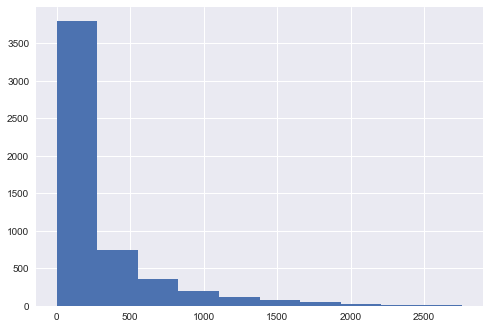

In [181]:
rf = rf.assign(daysdelta=rf.mean_timedelta.apply(lambda x: int(x / np.timedelta64(1, 'D'))))
_ = plt.hist(rf.daysdelta)

In [182]:
reviews1 = reviews1.join(rf.set_index('name'), on='name')
reviews1.head()

,asin,name,rating,date,verified,title,body,helpful_votes,mean_timedelta,daysdelta
2,B0000SX2UC,Brooke,5,2003-12-30,False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,1431 days 08:00:00,1431
7,B0000SX2UC,Matt,4,2004-04-03,False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0,163 days 17:49:42.857142858,163
9,B0000SX2UC,Amazon Customer,3,2004-02-02,False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0,0 days 21:24:50.685521057,0
15,B0009N5L7K,William B.,4,2006-02-09,False,Exellent Service,I have been with nextel for nearly a year now ...,NaN,1607 days 00:00:00,1607
21,B000SKTZ0S,Thomas,4,2010-09-17,True,"Nice, but",I bought this phone to replace an LG phone tha...,NaN,240 days 20:34:17.142857144,240


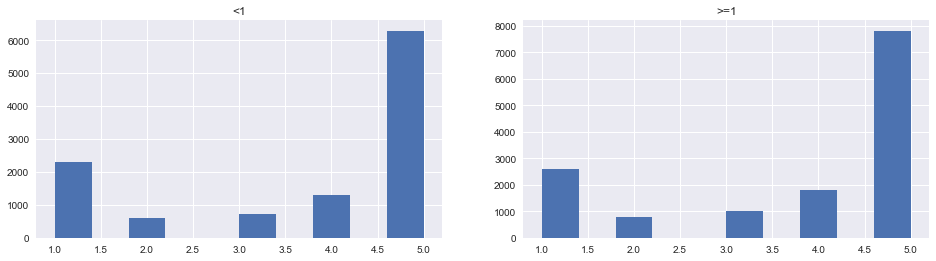

In [183]:
border = 1
groups = ['<{}'.format(border), '>={}'.format(border)]
reviews1 = reviews1.assign(daysdelta_grp=reviews1.daysdelta.apply(lambda x: groups[0] if x<border else groups[1]))
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for i, grp in enumerate(groups):
    axs[i].hist(reviews1.loc[reviews1.daysdelta_grp==grp, 'rating'])
    axs[i].set_title(grp)

Merging brand name instead off asin number, dropping rows with unplugged brand

In [184]:
reviews1 = reviews1[['name', 'asin', 'rating']].join(items[['asin', 'brand']].set_index('asin'), on='asin')
reviews1 = reviews1[reviews1.brand.isnull()==False]
reviews1.drop(['asin'], axis='columns', inplace=True)
print('sample length: {}'.format(reviews1.shape[0]))
reviews1.head()

sample length: 25171


,name,rating,brand
15,William B.,4,Motorola
21,Thomas,4,Motorola
23,Kristy,1,Motorola
27,Amazon Customer,1,Motorola
39,Linda,4,Motorola


Extracting a feature vector for each brand

In [185]:
# spand brand in columns, one for each brand
def func(x):
    x[x.brand] = 1
    return x

reviews1 = reviews1.apply(func, axis=1)
reviews1.drop(['brand'], axis='columns', inplace=True)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,name,rating
15,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,William B.,4
21,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Thomas,4
23,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Kristy,1
27,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Amazon Customer,1
39,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Linda,4


Setting rating value instead of flags

In [186]:
cols = reviews1.columns.tolist()
for col in ['name', 'rating']:
    cols.remove(col)

reviews1[cols] = reviews1[cols].mul(reviews1['rating'], axis=0)
reviews1.drop(['rating'], axis='columns', inplace=True)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,name
15,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,William B.
21,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Thomas
23,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Kristy
27,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Amazon Customer
39,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Linda


Customers have reviews of phones with same brand. So it is needed to calculate mean value of rating in reviews of phones with same brands from one customer

In [187]:
reviews1 = reviews1.groupby(['name']).mean()
print('sample length: {}'.format(reviews1.shape[0]))
reviews1.head()

sample length: 5380


,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi
name,,,,,,,,,,
#AmazonCustomer,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN
12TreW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
16Paws,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


In [232]:
reviews1 = reviews1.fillna(value=0)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi
name,,,,,,,,,,
#AmazonCustomer,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0
12TreW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
16Paws,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


In [260]:
border = int(0.7*reviews1.shape[0])

train_data = reviews1[:border]
test_data = reviews1[border:]

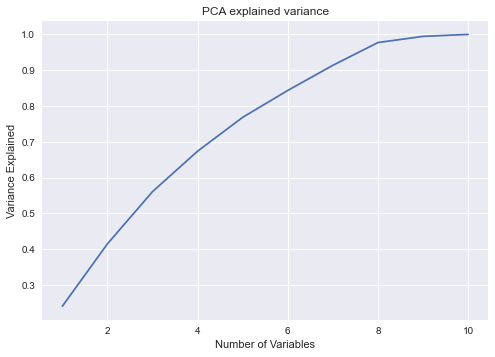

In [190]:
pca = PCA()
pca.fit(train_data)
acc_var = np.cumsum(pca.explained_variance_ratio_) 

plt.style.use('seaborn')
plt.plot(range(1, len(acc_var)+1), acc_var)
plt.title('PCA explained variance')
plt.xlabel('Number of Variables')
_ = plt.ylabel('Variance Explained')

In [191]:
number_of_components = 8
pca.set_params(n_components=number_of_components)
pca.fit(train_data)
train_data_pca = pca.transform(train_data)
train_data_pos_pca = pd.DataFrame(train_data_pca)
train_data_pos_pca['name'] = train_data.index
train_data_pos_pca = train_data_pos_pca.set_index('name')
train_data_pos_pca.head()

,0,1,2,3,4,5,6,7
name,,,,,,,,
#AmazonCustomer,1.932634,-1.550800,-0.087674,-1.544709,1.135260,2.295009,-1.250735,0.059627
.,0.922245,-1.251541,-0.025263,-0.997946,1.534690,-1.179878,-0.673594,-0.076272
0,-2.520847,0.335975,0.103006,0.446027,1.839039,-1.518106,-0.877389,-0.597305
12TreW,1.167700,-1.651027,-0.872911,-0.549663,-0.038026,-0.174956,-0.108341,0.159098
16Paws,-2.654427,-0.715605,-0.124148,0.348280,-0.247265,0.025118,0.010243,-0.067775


100%|██████████| 98/98 [00:37<00:00,  2.62it/s]


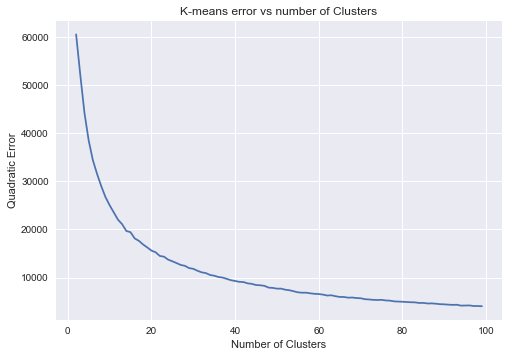

In [192]:
inertia = []
scores = []
for n_clusters in tqdm(range(2, 100)):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(train_data_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 100), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Quadratic Error')
_ = plt.title('K-means error vs number of Clusters')

In [201]:
#project the users feature vector in 3 dimensions
reviews_with_label = pd.DataFrame(PCA(n_components=3).fit_transform(train_data))
reviews_with_label['name'] = train_data.index
reviews_with_label = reviews_with_label.set_index('name')

#find each user's cluster
kmeans = KMeans(n_clusters=10, n_init=30)
train_data_with_label = train_data.assign(label=kmeans.fit_predict(train_data_pos_pca))
reviews_with_label.label = train_data_with_label.label
train_data_with_label.head()

<ipython-input-201-855567f387ce>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  reviews_with_label.label = train_data_with_label.label


,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
name,,,,,,,,,,,
#AmazonCustomer,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
.,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,8
12TreW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
16Paws,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3


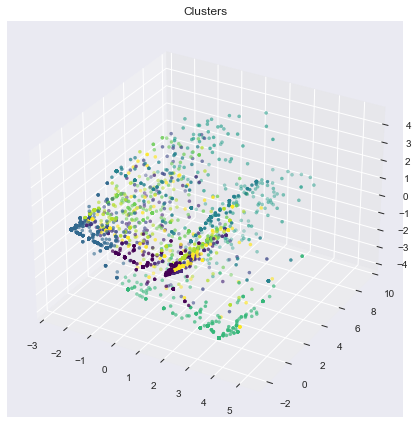

In [202]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(
    reviews_with_label[0], reviews_with_label[1], reviews_with_label[2],
    c=reviews_with_label.label, cmap='viridis', s=10
)
_ = plt.title('Clusters')

Distribution of customers number in clusters

In [203]:
print('Cluster ID     Number of users in cluster')
for idx, val in (pd.get_dummies(reviews_with_label.label)).sum().iteritems():
    print(f'{idx}              {val}')

Cluster ID     Number of users in cluster
0              500
1              176
2              161
3              1230
4              401
5              165
6              390
7              321
8              218
9              203


In [266]:
train_data_with_label = train_data_with_label.reset_index()
train_data_with_label.head()

,index,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
0,0,#AmazonCustomer,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
1,1,.,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,0
2,2,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,8
3,3,12TreW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0
4,4,16Paws,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3


In [267]:
for col in train_data_with_label.columns[1:-1]:
    train_data_with_label.loc[train_data_with_label[col]==0, col] = np.nan
train_data_with_label.head()

,index,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
0,0,#AmazonCustomer,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
1,1,.,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,0
2,2,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,8
3,3,12TreW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0
4,4,16Paws,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3


In [268]:
cols = train_data_with_label.columns[1:]
rm = train_data_with_label[cols].groupby(['label']).mean().reset_index()
rm

,label,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi
0,0,2.5,1.115789,1.333333,2.388889,1.885714,1.983871,4.666667,1.345274,1.281250,1.285714
1,1,NaN,2.812500,3.090909,3.666667,3.373984,3.153846,5.000000,3.710137,4.654356,4.188889
2,2,3.0,3.242188,2.546296,4.748447,3.391509,2.988095,3.571429,4.113086,3.635417,3.806667
3,3,3.4,1.655405,1.578947,1.222222,1.189922,1.256410,4.000000,4.572104,1.615385,2.500000
4,4,5.0,4.760806,2.250000,3.625000,3.331771,3.246667,5.000000,3.759227,2.875000,4.352273
5,5,3.3,4.025157,3.668096,4.394564,4.090452,3.963507,4.319746,3.920365,4.027105,4.437460
6,6,4.0,2.786458,2.000000,3.937500,3.504630,2.973684,5.000000,3.564286,3.761905,4.743590
7,7,3.0,3.127132,2.121622,1.333333,4.643510,2.500000,4.000000,3.853284,1.950000,4.045977
8,8,2.5,2.444444,2.550000,2.954545,3.388587,4.548165,4.750000,4.053273,3.272727,3.175439
9,9,4.0,3.733871,4.703448,3.821429,2.925463,2.636364,4.500000,3.722755,3.571429,4.034483


In [265]:
td = test_data
predicts = kmeans.predict(pca.transform(td))
td = td.reset_index()
td = td.assign(label=pd.DataFrame({'l': predicts}))
td.head()

,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
0,S.,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,1.0,0
1,S. Bickley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3
2,S. Brown,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3
3,S. J. Shaff,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0
4,S. Jones,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,7


In [271]:
def predict_ratings(x):
    for col in rm.columns[1:]:
        x['p_{}'.format(col)] = rm.loc[x.label, col]
    return x

td = td.apply(predict_ratings, axis=1)
td.to_csv('test_data.csv')
td.head()

,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,...,p_ASUS,p_Apple,p_Google,p_HUAWEI,p_Motorola,p_Nokia,p_OnePlus,p_Samsung,p_Sony,p_Xiaomi
0,S.,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,...,2.5,1.115789,1.333333,2.388889,1.885714,1.983871,4.666667,1.345274,1.281250,1.285714
1,S. Bickley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,3.4,1.655405,1.578947,1.222222,1.189922,1.256410,4.000000,4.572104,1.615385,2.500000
2,S. Brown,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,3.4,1.655405,1.578947,1.222222,1.189922,1.256410,4.000000,4.572104,1.615385,2.500000
3,S. J. Shaff,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,...,2.5,1.115789,1.333333,2.388889,1.885714,1.983871,4.666667,1.345274,1.281250,1.285714
4,S. Jones,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.5,0.0,...,3.0,3.127132,2.121622,1.333333,4.643510,2.500000,4.000000,3.853284,1.950000,4.045977


In [275]:
brand = 'Motorola'
td.loc[td[brand]>0, ['label', brand, 'p_'+brand]].head(20)

,label,Motorola,p_Motorola
0,0,2.500000,1.885714
3,0,2.500000,1.885714
4,7,4.000000,4.643510
14,7,4.500000,4.643510
15,7,2.500000,4.643510
17,9,1.000000,2.925463
23,4,1.500000,3.331771
27,7,5.000000,4.643510
30,7,5.000000,4.643510
31,7,5.000000,4.643510


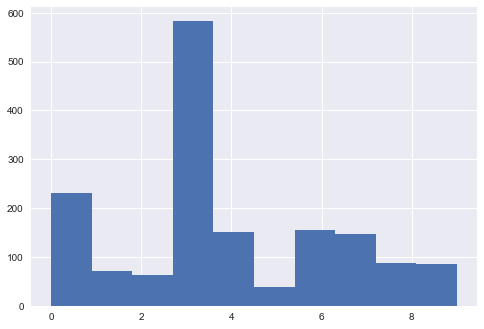

In [276]:
_ = plt.hist(td.label)